Como nuestra variable objetivo es un valor de 0-1, nuestro enfoque es de tipo regresion.

Se requiere construir un modelo de regresion que permita pronosticar la productividad  de cada empleado con un MAPE menor al 20%

In [20]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [21]:
data=pd.read_csv('garments_worker_productivity.csv')

In [22]:
data.head()

date   quarter  department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1      sweing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing   Thursday     1                   0.75   
2  1/1/2015  Quarter1      sweing  Thursday    11                   0.80   
3  1/1/2015  Quarter1      sweing  Thursday    12                   0.80   
4  1/1/2015  Quarter1      sweing  Thursday     6                   0.80   

     smv     wip  over_time  incentive  idle_time  idle_men  \
0  26.16  1108.0       7080         98        0.0         0   
1   3.94     NaN        960          0        0.0         0   
2  11.41   968.0       3660         50        0.0         0   
3  11.41   968.0       3660         50        0.0         0   
4  25.90  1170.0       1920         50        0.0         0   

   no_of_style_change  no_of_workers  actual_productivity  
0                   0           59.0             0.940725  
1                   0            8.0             0.886500  
2                   0           30.5             0.800570  
3                   0           30.5             0.800570  
4                   0           56.0             0.800382

In [23]:
import matplotlib.pyplot as plt
import seaborn as sb
from ydata_profiling import ProfileReport


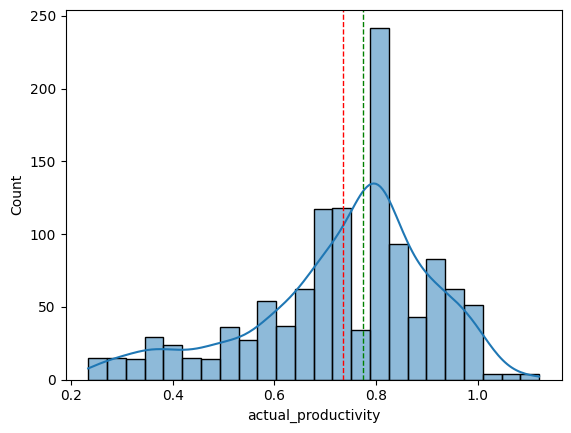

In [24]:
sb.histplot(data=data, x='actual_productivity', kde=True)
plt.axvline(data['actual_productivity'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(data['actual_productivity'].median(), color='green', linestyle='dashed', linewidth=1)
plt.show()

In [25]:
profile=ProfileReport (data)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Preparacion de datos
- Elimnar la vairbale idlemaen e idletime del conjunto
- Nulos de wip por 0
- Modificar finishing department
- Ajustar las varibales por tipo para modelo

In [26]:
data_mod=data.copy()    
data_mod=data.drop(['idle_time','idle_men'],axis=1)
data_mod['wip'].fillna(0, inplace=True)
data_mod['department'].replace({'finishing ':'finishing'},inplace=True)
data_mod['date']=pd.to_datetime(data_mod['date'],format='%m/%d/%Y')
data_mod['num_day']=[i.day for i in data_mod.date]
data_mod['month']=[i.month for i in data_mod.date]
data_mod['year']=[i.year for i in data_mod.date]
data_mod.drop(['date'],axis=1,inplace=True)
data_mod.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   wip                    1197 non-null   float64
 7   over_time              1197 non-null   int64  
 8   incentive              1197 non-null   int64  
 9   no_of_style_change     1197 non-null   int64  
 10  no_of_workers          1197 non-null   float64
 11  actual_productivity    1197 non-null   float64
 12  num_day                1197 non-null   int64  
 13  month                  1197 non-null   int64  
 14  year                   1197 non-null   int64  
dtypes: f

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

## En regresion es buena idea colocar en el endocer la variable objetivo

In [28]:
num_col=data_mod.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_col=data_mod.select_dtypes(include=['object']).columns.to_list()

num_transformer= Pipeline(steps=[('scaler', MinMaxScaler())])
cat_transformer= Pipeline(steps=[('encoder', OneHotEncoder())])

preprocessor= ColumnTransformer(transformers=[('num', num_transformer, num_col),
                                            ('cat', cat_transformer, cat_col)],
                                            remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['team', 'targeted_productivity', 'smv', 'wip',
                                  'over_time', 'incentive',
                                  'no_of_style_change', 'no_of_workers',
                                  'actual_productivity', 'num_day', 'month',
                                  'year']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['quarter', 'department', 'day'])])

In [29]:
data_pre=preprocessor.fit_transform(data_mod)
cod_cat=preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_col)
labels=np.concatenate([num_col,cod_cat])

data_pro=pd.DataFrame(data_pre, columns=labels)
data_pro.head()

team  targeted_productivity       smv       wip  over_time  incentive  \
0  0.636364               1.000000  0.450252  0.047920   0.273148   0.027222   
1  0.000000               0.931507  0.020132  0.000000   0.037037   0.000000   
2  0.909091               1.000000  0.164731  0.041865   0.141204   0.013889   
3  1.000000               1.000000  0.164731  0.041865   0.141204   0.013889   
4  0.454545               1.000000  0.445219  0.050601   0.074074   0.013889   

   no_of_style_change  no_of_workers  actual_productivity  num_day  ...  \
0                 0.0       0.655172             0.797332      0.0  ...   
1                 0.0       0.068966             0.736180      0.0  ...   
2                 0.0       0.327586             0.639274      0.0  ...   
3                 0.0       0.327586             0.639274      0.0  ...   
4                 0.0       0.620690             0.639062      0.0  ...   

   quarter_Quarter4  quarter_Quarter5  department_finishing  \
0               0.0               0.0                   0.0   
1               0.0               0.0                   1.0   
2               0.0               0.0                   0.0   
3               0.0               0.0                   0.0   
4               0.0               0.0                   0.0   

   department_sweing  day_Monday  day_Saturday  day_Sunday  day_Thursday  \
0                1.0         0.0           0.0         0.0           1.0   
1                0.0         0.0           0.0         0.0           1.0   
2                1.0         0.0           0.0         0.0           1.0   
3                1.0         0.0           0.0         0.0           1.0   
4                1.0         0.0           0.0         0.0           1.0   

   day_Tuesday  day_Wednesday  
0          0.0            0.0  
1          0.0            0.0  
2          0.0            0.0  
3          0.0            0.0  
4          0.0            0.0  

[5 rows x 25 columns]

In [30]:
from sklearn.model_selection import train_test_split
X=data_pro.drop(['actual_productivity'],axis=1)
y=data_pro['actual_productivity']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.7)

In [31]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(359, 24) (838, 24) (359,) (838,)


# Modeldao y validacion tecnica

- Regreson lineal
- SVM
- KMEAN
- Decision tree
- Random forest
- Adaptative Boosting
- Gradient Boosting
- Perceptron Multicapa


In [32]:
# Modeldao y validacion tecnica
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error



In [33]:
modelo_1 = LinearRegression()
modelo_2 = SVR()
modelo_3 = KNeighborsRegressor()
modelo_4 = DecisionTreeRegressor()
modelo_5 = RandomForestRegressor()
modelo_6 = AdaBoostRegressor()
modelo_7 = GradientBoostingRegressor()
modelo_8 = MLPRegressor()

R2: 0.1309713909790915
RMSE: 0.18138536922691242
MAE: 0.13385356279178737
MAPE: 0.8576671716106935


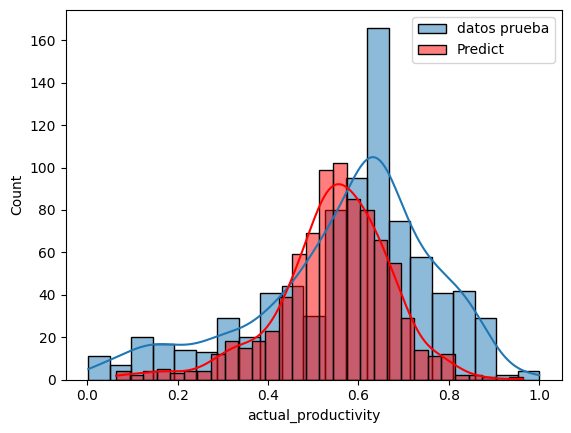

In [34]:
modelo_1.fit(X_train, y_train)
predict_1=modelo_1.predict(X_test)
y_test_des= y_test * (np.max(y) - np.min(y)) + np.min(y)
predict_1_des= predict_1 * (np.max(y) - np.min(y)) + np.min(y)


r2_1=r2_score(y_test_des, predict_1_des)
rmse_1=mean_squared_error(y_test_des, predict_1_des, squared=False)
mae_1=mean_absolute_error(y_test_des, predict_1_des)
mape_1=mean_absolute_percentage_error(y_test_des, predict_1_des)

print('R2:', r2_1)
print('RMSE:', rmse_1)
print('MAE:', mae_1)
print('MAPE:', mape_1)

sb.histplot(y_test_des, kde=True, label="datos prueba")
sb.histplot(predict_1_des, kde=True, color='red', label='Predict')
plt.legend()
plt.show()

# Maquina de soporte vectorial

In [35]:
# Busqueda de hiperparametros

hiper_grid= {'C':[0,0.0001,0.001,0.01,0.1,1,10,100],
             'kernel':['linear','poly','rbf','sigmoid'],
                'degree':[2,3,4,5]}
regressor= GridSearchCV(modelo_2, param_grid=hiper_grid, cv=3)
regressor.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(regressor.cv_results_["params"]),
                        pd.DataFrame(regressor.cv_results_["mean_test_score"],
                                    columns=["Ajuste"])],
                                    axis=1)
validation.sort_values("Ajuste", ascending=False)

C  degree   kernel    Ajuste
120  100.0       4   linear  0.284473
124  100.0       5   linear  0.284473
116  100.0       3   linear  0.284473
112  100.0       2   linear  0.284473
96    10.0       2   linear  0.282283
..     ...     ...      ...       ...
11     0.0       4  sigmoid       NaN
12     0.0       5   linear       NaN
13     0.0       5     poly       NaN
14     0.0       5      rbf       NaN
15     0.0       5  sigmoid       NaN

[128 rows x 4 columns]

In [36]:
modelo_2_final=regressor.best_estimator_
modelo_2_final

SVR(C=100, degree=2, kernel='linear')

In [37]:
predict_2=modelo_2_final.predict(X_test)
predict_2_des= predict_2 * (np.max(y) - np.min(y)) + np.min(y)

R2: 0.1336685137902649
RMSE: 0.18110367608840366
MAE: 0.13054467277345652
MAPE: 0.8668734064289024


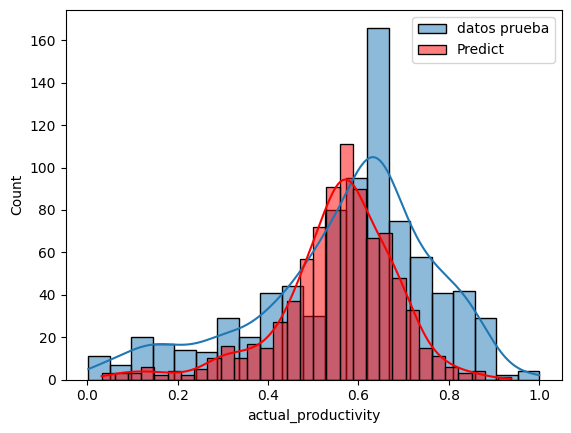

In [38]:

r2_2=r2_score(y_test_des, predict_2_des)
rmse_2=mean_squared_error(y_test_des, predict_2_des, squared=False)
mae_2=mean_absolute_error(y_test_des, predict_2_des)
mape_2=mean_absolute_percentage_error(y_test_des, predict_2_des)

print('R2:', r2_2)
print('RMSE:', rmse_2)
print('MAE:', mae_2)
print('MAPE:', mape_2)

sb.histplot(y_test_des, kde=True, label="datos prueba")
sb.histplot(predict_2_des, kde=True, color='red', label='Predict')
plt.legend()
plt.show()

# K vecinos mas cercanos

In [39]:
# Busqueda de hiperparametros

hiper_grid= {'n_neighbors':[2,3,4,5,8,10,20,100],
             'p':[1,2]}

regressor= GridSearchCV(modelo_3, param_grid=hiper_grid, cv=3)
regressor.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(regressor.cv_results_["params"]),
                        pd.DataFrame(regressor.cv_results_["mean_test_score"],
                                    columns=["Ajuste"])],
                                    axis=1)
validation.sort_values("Ajuste", ascending=False)


n_neighbors  p    Ajuste
12           20  1  0.030989
14          100  1  0.018542
15          100  2  0.011983
13           20  2  0.008241
10           10  1  0.006950
8             8  1 -0.016764
11           10  2 -0.023635
9             8  2 -0.048145
6             5  1 -0.125456
7             5  2 -0.151945
4             4  1 -0.159163
5             4  2 -0.213783
2             3  1 -0.267496
3             3  2 -0.287404
0             2  1 -0.415101
1             2  2 -0.517499

In [40]:
modelo_3_final=regressor.best_estimator_
modelo_3_final

KNeighborsRegressor(n_neighbors=20, p=1)

In [41]:
predict_3=modelo_3_final.predict(X_test)
predict_3_des= predict_3 * (np.max(y) - np.min(y)) + np.min(y)

R2: 0.07712691222442047
RMSE: 0.1869201871562693
MAE: 0.14509137373847644
MAPE: 0.9484587088668144


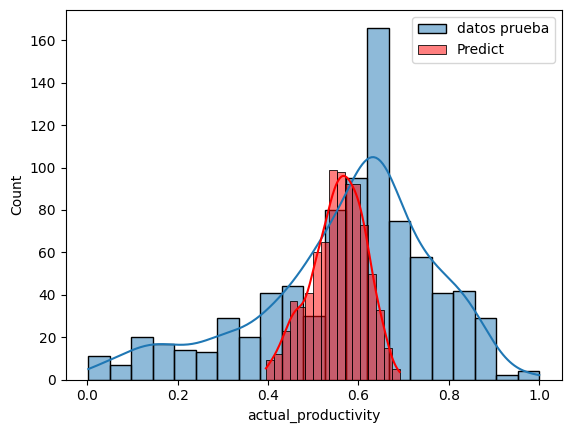

In [42]:

r2_3=r2_score(y_test_des, predict_3_des)
rmse_3=mean_squared_error(y_test_des, predict_3_des, squared=False)
mae_3=mean_absolute_error(y_test_des, predict_3_des)
mape_3=mean_absolute_percentage_error(y_test_des, predict_3_des)

print('R2:', r2_3)
print('RMSE:', rmse_3)
print('MAE:', mae_3)
print('MAPE:', mape_3)

sb.histplot(y_test_des, kde=True, label="datos prueba")
sb.histplot(predict_3_des, kde=True, color='red', label='Predict')
plt.legend()
plt.show()

# Arboles de Decision

In [55]:
# Busqueda de hiperparametros

hiper_grid= {'criterion':['squared_error','absolute_error','friedman_mse','poisson'],
             'max_depth':[5,10,15,20,None],
             'max_leaf_nodes':[10,12,15],
             'min_samples_split':[2,5,10]}

regressor= GridSearchCV(modelo_4, param_grid=hiper_grid, cv=3)
regressor.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(regressor.cv_results_["params"]),
                        pd.DataFrame(regressor.cv_results_["mean_test_score"],
                                    columns=["Ajuste"])],
                                    axis=1)
validation.sort_values("Ajuste", ascending=False)

criterion  max_depth  max_leaf_nodes  min_samples_split    Ajuste
63   absolute_error       15.0              10                  2  0.181736
56   absolute_error       10.0              10                 10  0.181736
54   absolute_error       10.0              10                  2  0.181736
55   absolute_error       10.0              10                  5  0.181736
73   absolute_error       20.0              10                  5  0.181736
..              ...        ...             ...                ...       ...
179         poisson        NaN              15                 10  0.073508
143         poisson        5.0              15                 10  0.072790
140         poisson        5.0              12                 10  0.065589
141         poisson        5.0              15                  2  0.007725
142         poisson        5.0              15                  5  0.007719

[180 rows x 5 columns]

In [56]:
modelo_4_final=regressor.best_estimator_
modelo_4_final

DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                      max_leaf_nodes=10)

In [60]:
predict_4=modelo_4_final.predict(X_test)
predict_4_des= predict_4 * (np.max(y) - np.min(y)) + np.min(y)

Profundidad del arbol: 6
 Numero de hojas: 10


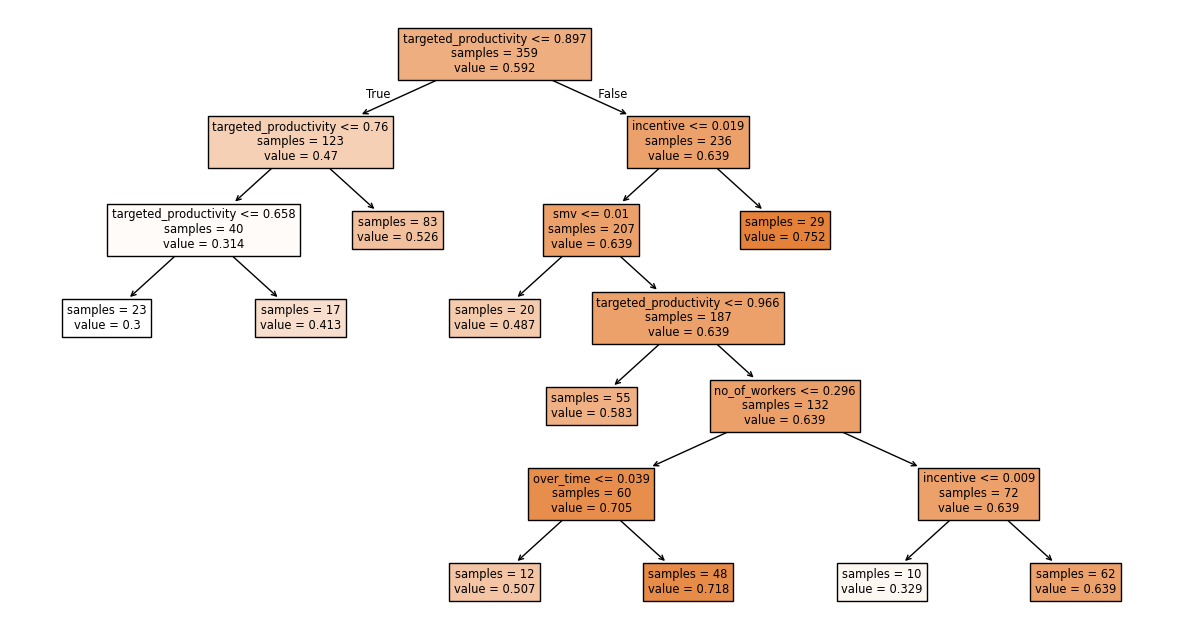

In [61]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(15,8))
print(f'Profundidad del arbol: {modelo_4_final.get_depth()}\n Numero de hojas: {modelo_4_final.get_n_leaves()}')
plot= plot_tree(decision_tree=modelo_4_final,
                feature_names=labels,
               filled=True,
               impurity=False,
               ax=ax)


R2: 0.2756901003655141
RMSE: 0.1655950790964256
MAE: 0.10494490383991531
MAPE: 0.848287359017664


<function matplotlib.pyplot.show(close=None, block=None)>

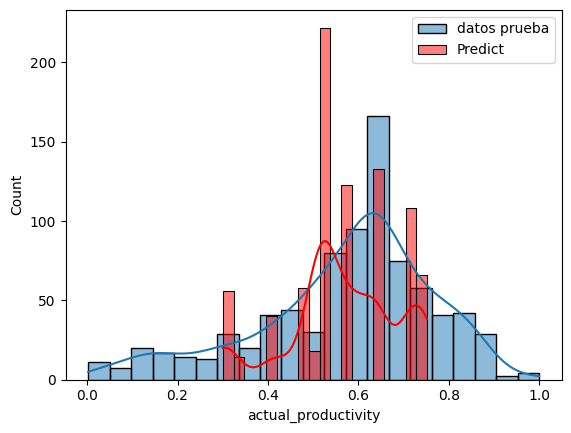

In [62]:

r2_4=r2_score(y_test_des, predict_4_des)
rmse_4=mean_squared_error(y_test_des, predict_4_des, squared=False)
mae_4=mean_absolute_error(y_test_des, predict_4_des)
mape_4=mean_absolute_percentage_error(y_test_des, predict_4_des)

print('R2:', r2_4)
print('RMSE:', rmse_4)
print('MAE:', mae_4)
print('MAPE:', mape_4)

sb.histplot(y_test_des, kde=True, label="datos prueba")
sb.histplot(predict_4_des, kde=True, color='red', label='Predict')
plt.legend()
plt.show

# Random Tree

In [63]:
# Busqueda de hiperparametros

hiper_grid= {'criterion':['squared_error','absolute_error','friedman_mse','poisson'],
             'max_depth':[5,10,15,20,None],
             'n_estimators':[100,200,500,1000,1500]}

regressor= GridSearchCV(modelo_5, param_grid=hiper_grid, cv=3)
regressor.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(regressor.cv_results_["params"]),
                        pd.DataFrame(regressor.cv_results_["mean_test_score"],
                                    columns=["Ajuste"])],
                                    axis=1)
validation.sort_values("Ajuste", ascending=False)

criterion  max_depth  n_estimators    Ajuste
41  absolute_error       20.0           200  0.365793
30  absolute_error       10.0           100  0.361284
91         poisson       20.0           200  0.361013
56    friedman_mse       10.0           200  0.360766
60    friedman_mse       15.0           100  0.360630
..             ...        ...           ...       ...
77         poisson        5.0           500  0.325649
76         poisson        5.0           200  0.320766
78         poisson        5.0          1000  0.320431
75         poisson        5.0           100  0.319944
79         poisson        5.0          1500  0.317008

[100 rows x 4 columns]

In [64]:
modelo_5_final=regressor.best_estimator_
modelo_5_final

RandomForestRegressor(criterion='absolute_error', max_depth=20,
                      n_estimators=200)

In [65]:
predict_5=modelo_5_final.predict(X_test)
predict_5_des= predict_5 * (np.max(y) - np.min(y)) + np.min(y)

R2: 0.37188664485965917
RMSE: 0.1542070503841764
MAE: 0.10060190410744232
MAPE: 0.7565297326713066


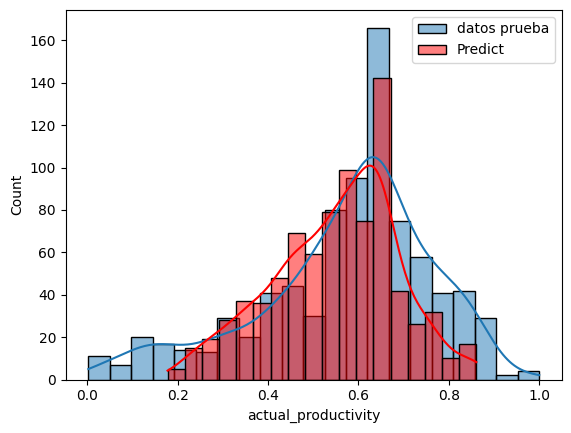

In [69]:

r2_5=r2_score(y_test_des, predict_5_des)
rmse_5=mean_squared_error(y_test_des, predict_5_des, squared=False)
mae_5=mean_absolute_error(y_test_des, predict_5_des)
mape_5=mean_absolute_percentage_error(y_test_des, predict_5_des)

print('R2:', r2_5)
print('RMSE:', rmse_5)
print('MAE:', mae_5)
print('MAPE:', mape_5)

sb.histplot(y_test_des, kde=True, label="datos prueba")
sb.histplot(predict_5_des, kde=True, color='red', label='Predict')
plt.legend()
plt.show()